# DDPLKO Moduł 6 - praca domowa - Data augmentation

To szósta praca domowa w Programie szkoleniowym Klasyfikacja obrazu od Deep Drive PL

Twoim zadaniem w tym module będzie:
- [ ] Na bazie ostatniej pracy domowej z Transfer learningiem
- [ ] Dobierz Data augmentation do zbioru danych, tak aby generowane zdjęcia były podobne do zbioru Val
- [ ] Wyświetl przykłady przed i po data augmentation
- [ ] Wykonaj trening klasyfikatora oraz całej sieci (fine tuning) wykorzystując data augmentation
- [ ] Przygotuj wykres w którym porównasz 2 treningi - bez data augmentation i z data augmentation
- [ ] Udostępnij wykres na Discordzie `#klasyfikacja-wyniki` (val acc)

Możesz (czyli opcjonalne rzeczy):
- wykonać tylko trening klasyfikatora, bez fine tuningu, jeżeli masz ograniczone zasoby
- zwizualizować dodatkowo i wskazać zmiany:
  - confussion matrix - gdzie jest lepiej, gdzie gorzej
  - błędne przypadki - które próbki już są poprawnie klasyfikowane, a które przestały być

# Zbiór danych

In [1]:
from pathlib import Path
import json
import os
import albumentations as A
from torchvision import transforms
import numpy as np
from torchvision.io import read_image
from torch.utils.data import Dataset
data_dir = Path('/home/jakub/Documents/deep_learning_course/05/weather_classification')
classes = os.listdir(data_dir)

## Podział zbioru

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import cv2

images = []
labels = []
for cls in classes:
    for img in os.listdir(data_dir / cls):
        images.append(img)
        labels.append(cls)
        
X_train, X_testval, y_train, y_testval = train_test_split(images, labels, test_size=0.3, random_state=42,
                                                         stratify=labels)
X_test, X_val, y_test, y_val = train_test_split(X_testval, y_testval, test_size=0.5, random_state=42,
                                               stratify=y_testval)

assert len(set(y_val)) == len(set(y_train)) == len(set(y_test))

le = LabelEncoder()
le.fit(classes)
classes = le.classes_.tolist()

y_train = le.transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)

annotations = {'train': {'images': X_train,
                        'labels': y_train,
                        'classes': classes},
              
               'test': {'images': X_test,
                        'labels': y_test,
                        'classes': classes},
              
               'val': {'images': X_val,
                        'labels': y_val,
                        'classes': classes}}

# Data augmentation

In [3]:
import torch
input_size=(192, 192)

augmentation = A.Compose([A.Blur(p=0.3),
                       A.RandomCrop(160, 160, p=0.6),
                       A.HorizontalFlip(p=0.2),
                       A.Rotate(30, value=0, border_mode=0, p=0.4),
                       A.RandomBrightnessContrast(),
                       A.PadIfNeeded(min_height=input_size[0], min_width=input_size[1])
                     
])


img_transforms = transforms.Compose([
    transforms.Resize(input_size)
])
class CustomDataset(Dataset):
    def __init__(self, annotations:dict, img_dir:Path, transform=None, augmentation=None, target_transform=None):
        self.annotations=annotations
        self.img_dir=img_dir
        self.transform=transform
        self.augmentation=augmentation
        self.target_transform=target_transform
        self.classes = annotations['classes']
        
    def __len__(self):
        return len(self.annotations['images'])

    def __getitem__(self, idx):
        img_cat = self.annotations['images'][idx].split('_')[0]
        img_path = str(self.img_dir / img_cat / self.annotations['images'][idx])
        image = read_image(img_path)
        image = image / 255.0
        label = self.classes.index(img_cat)
        
        if self.transform:
            image = self.transform(image)
            
        if self.augmentation:
            image = augmentation(image=image.numpy().transpose((1, 2, 0)))['image']
            image = torch.Tensor(image).permute((2, 0, 1))
            
        if self.target_transform is not None:
            label = self.target_transform([label]).to(torch.long)
            
        return image, label

## Data augmentation - examples

In [4]:
import matplotlib.pyplot as plt
aug_train_dataset = CustomDataset(annotations['train'], 
                             img_dir=data_dir, 
                             transform=img_transforms,
                             augmentation=augmentation)
train_dataset = CustomDataset(annotations['train'], 
                             img_dir=data_dir, 
                             transform=img_transforms)

def visualize(dataset):
    img_ids = np.random.randint(len(dataset), size=len(dataset.classes))
    plt.figure(figsize=(15, 15))
    for i, img_id in enumerate(img_ids):
        plt.subplot(2, 3, i+1)
        img, label = dataset[img_id]
        label = dataset.classes[label]
        plt.imshow(img.numpy().transpose((1, 2, 0)))
        plt.title(label)
        plt.axis('off')
    plt.tight_layout()

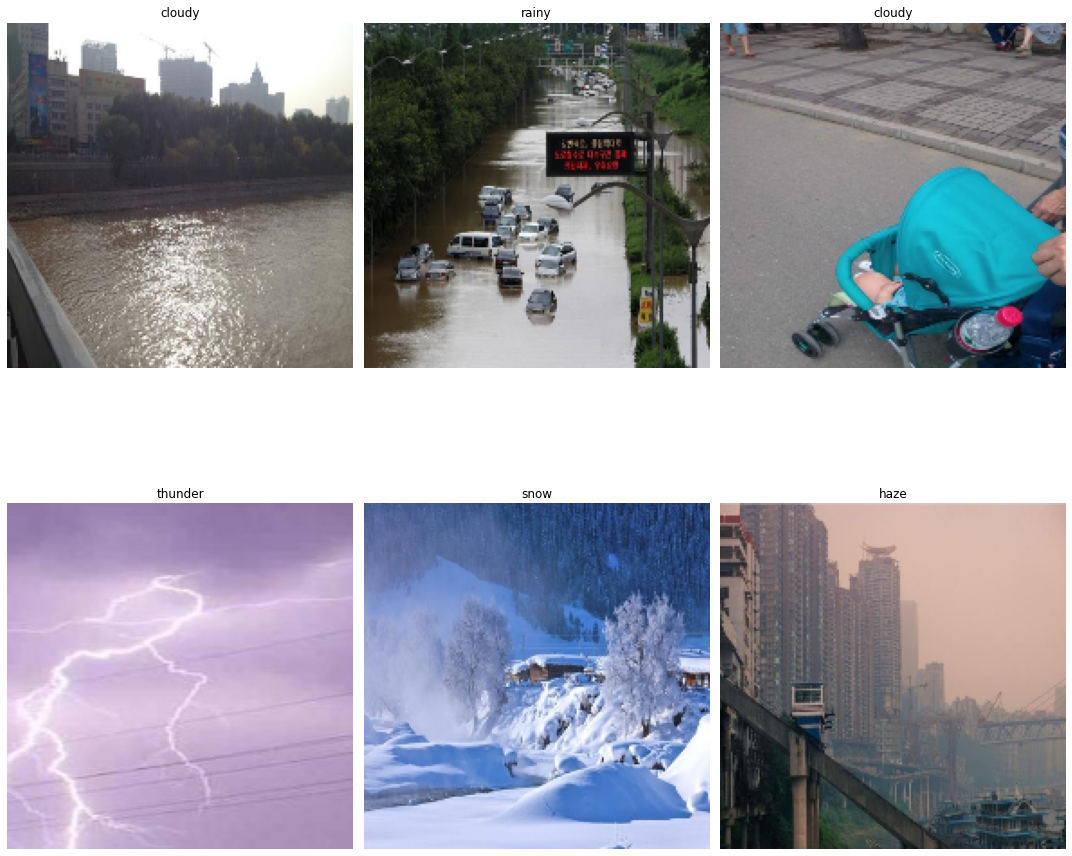

In [5]:
# non augmented
visualize(train_dataset)

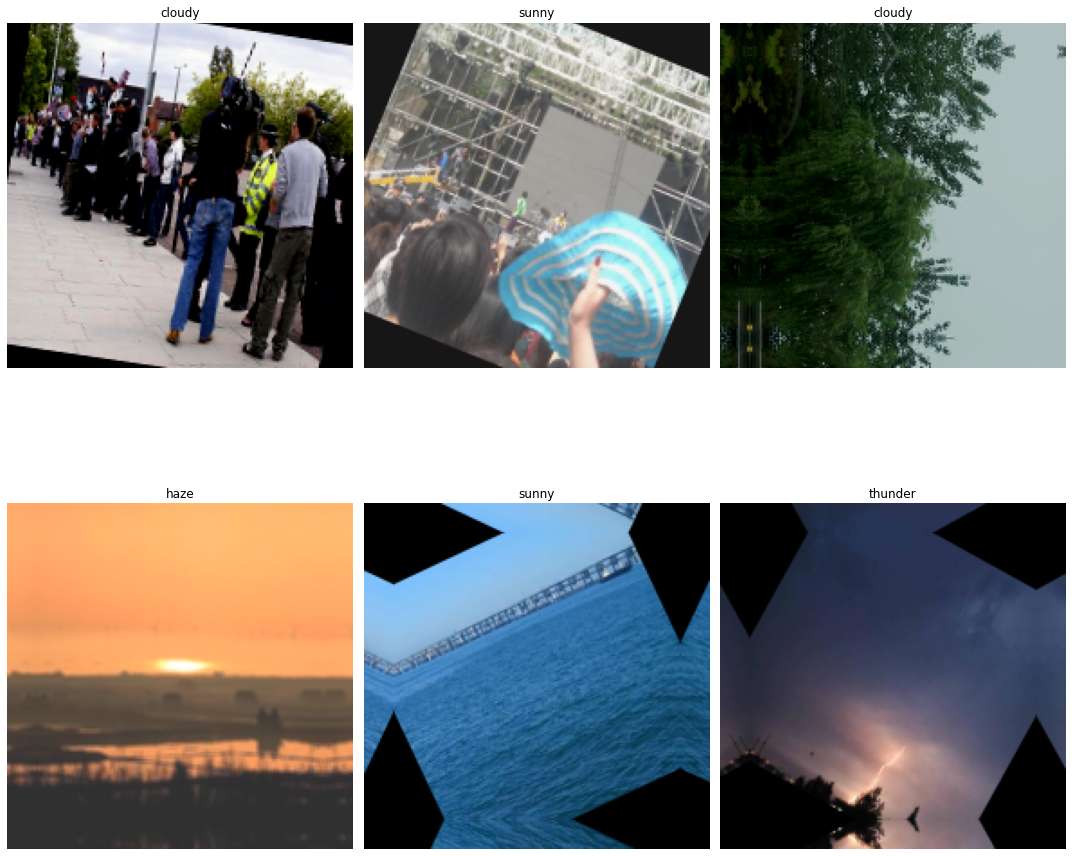

In [11]:
# augmented
visualize(aug_train_dataset)

## Training freezed model with augmentation

In [5]:
from tqdm import tqdm
import timm
from torch import nn
from torchsummary import summary

In [19]:
device = torch.device('cuda')
model = timm.create_model('tf_efficientnetv2_b0', pretrained=True, num_classes=len(classes))
model.to(device)

total = len([1 for _ in model.parameters()])

for i,param in enumerate(model.parameters()):
    if i>=(total-2):
        param.requires_grad = True
    else:
        param.requires_grad = False
summary(model,(3, 192, 192))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
        Conv2dSame-1           [-1, 32, 96, 96]             864
       BatchNorm2d-2           [-1, 32, 96, 96]              64
              SiLU-3           [-1, 32, 96, 96]               0
            Conv2d-4           [-1, 16, 96, 96]           4,608
       BatchNorm2d-5           [-1, 16, 96, 96]              32
              SiLU-6           [-1, 16, 96, 96]               0
         ConvBnAct-7           [-1, 16, 96, 96]               0
        Conv2dSame-8           [-1, 64, 48, 48]           9,216
       BatchNorm2d-9           [-1, 64, 48, 48]             128
             SiLU-10           [-1, 64, 48, 48]               0
         Identity-11           [-1, 64, 48, 48]               0
           Conv2d-12           [-1, 32, 48, 48]           2,048
      BatchNorm2d-13           [-1, 32, 48, 48]              64
     EdgeResidual-14           [-1, 32,

In [6]:
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim
from datetime import datetime

In [7]:
def torch_train(model, optimizer, early_stopping: bool, epochs: int, 
                batch_size: int, model_name, train_dataset, val_dataset,
                patience=3, save_models=False):
    """Trains torch model"""
    device = torch.device('cuda')
    print(device)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                             num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True,
                           num_workers=2)


    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    current_patience = 0
    highest_acc = 0
    
    progress_bar = tqdm(list(range(1, epochs + 1)))
    for epoch in progress_bar:
        
        model.train()
        train_loss=0
        correct=0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = nn.CrossEntropyLoss()(output, target)
            loss.backward()
            optimizer.step()

            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().detach()
            train_loss+=loss.detach()
            
        train_loss/=len(train_loader)
        acc = correct / float(len(train_loader.dataset))
        train_losses.append(train_loss)
        train_accs.append(acc)
        
        # log scalars to Tensorboard
        writer.add_scalar('train/acc', acc, epoch)
        writer.add_scalar('train/loss', train_loss, epoch)
        
        model.eval()
        val_loss = 0
        correct = 0
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                val_loss += nn.CrossEntropyLoss()(output, target).sum().detach()
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().detach()


        val_loss /= len(val_loader.dataset)
        val_acc = correct / float(len(val_loader.dataset))
        
        progress_bar.set_description('Val loss: {:.4f}, val acc: {:.4f}'.format(val_loss, val_acc))
        
         #log scalars to Tensorboard
        writer.add_scalar('val/acc', val_acc, epoch)
        writer.add_scalar('val/loss', val_loss, epoch)
        
        # early stopping
        if early_stopping:
            if val_acc > highest_acc:
                highest_acc = val_acc
                current_patience = 0
                
            if len(val_accs) > 0:
                if val_acc < highest_acc:
                    current_patience += 1
                    if current_patience == patience:
                        print(f'Early stopped at {epoch} epoch. Current val_acc: {val_acc}. Last val_acc: {val_accs[-1]}')
                        break
                        
        if save_models:
            if len(val_accs) > 0:
                if val_acc > max(val_accs):
                    torch.save(model.state_dict(), f'./{model_name}_{epoch}_epoch.pt')
        
        val_losses.append(val_loss)
        val_accs.append(val_acc)
    # log metrics and params to TensorBoard HParams
    writer.add_hparams({'model_name': model_name,
                        'epochs': epochs,
                        'batch_size': batch_size,
                        'params_count': sum(p.numel() for p in model.parameters()),
                       'lr': optimizer.param_groups[0]['lr']},
                       {'hp/train_acc': acc,
                        'hp/val_acc': val_acc},
                       run_name=model_name)
        
    return model

In [1]:
from torch.utils import tensorboard
writer = tensorboard.SummaryWriter('/home/jakub/Documents/deep_learning_course/05/05.10/logs/weather_classification2/EffNetV2_pretrained_freezed_aug')


2021-09-14 19:01:23.704046: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [8]:
train_dataset = CustomDataset(annotations['train'], 
                             img_dir=data_dir, 
                             transform=img_transforms,
                             augmentation=augmentation)

val_dataset = CustomDataset(annotations['val'], 
                             img_dir=data_dir, 
                             transform=img_transforms)

In [38]:
optimizer = optim.Adam(model.parameters(), lr=0.003)
freezed_model = torch_train(model, optimizer, early_stopping=True, epochs=30, patience=4, batch_size=64, 
                    model_name='effnetv2_pretrained_freezed_aug', 
                    train_dataset=train_dataset, val_dataset=val_dataset)

cuda


Val loss: 0.0105, val acc: 0.7481:  30%|██▍     | 9/30 [19:46<46:08, 131.81s/it]

Early stopped at 10 epoch. Current val_acc: 0.7481382489204407. Last val_acc: 0.7490274310112


## Unfreeze model

In [50]:
from copy import deepcopy
total = len([1 for _ in freezed_model.parameters()])

unfreezed_model = deepcopy(freezed_model)

for i,param in enumerate(unfreezed_model.parameters()):
    param.requires_grad=True

summary(unfreezed_model, (3, 192, 192))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
        Conv2dSame-1           [-1, 32, 96, 96]             864
       BatchNorm2d-2           [-1, 32, 96, 96]              64
              SiLU-3           [-1, 32, 96, 96]               0
            Conv2d-4           [-1, 16, 96, 96]           4,608
       BatchNorm2d-5           [-1, 16, 96, 96]              32
              SiLU-6           [-1, 16, 96, 96]               0
         ConvBnAct-7           [-1, 16, 96, 96]               0
        Conv2dSame-8           [-1, 64, 48, 48]           9,216
       BatchNorm2d-9           [-1, 64, 48, 48]             128
             SiLU-10           [-1, 64, 48, 48]               0
         Identity-11           [-1, 64, 48, 48]               0
           Conv2d-12           [-1, 32, 48, 48]           2,048
      BatchNorm2d-13           [-1, 32, 48, 48]              64
     EdgeResidual-14           [-1, 32,

In [10]:
uf_model = timm.create_model('tf_efficientnetv2_b0', pretrained=True, num_classes=len(classes))
uf_model.load_state_dict(torch.load('unfreezed_effnetv2_aug.pth')())
device = torch.device('cuda')
uf_model.to(device);

## Fine tuning with augmentation

In [1]:
from torch.utils import tensorboard
writer = tensorboard.SummaryWriter('/home/jakub/Documents/deep_learning_course/05/05.10/logs/weather_classification2/EffNetV2_pretrained_unfreezed_aug')

2021-09-14 20:30:30.579802: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [11]:
optimizer = optim.Adam(uf_model.parameters(), lr=0.003)
unfreezed_model = torch_train(uf_model, optimizer, early_stopping=True, epochs=30, patience=4, batch_size=64, 
                    model_name='effnetv2_pretrained_unfreezed_aug', 
                    train_dataset=train_dataset, val_dataset=val_dataset)

cuda


Val loss: 0.0072, val acc: 0.8375:  67%|███▎ | 20/30 [1:22:58<41:29, 248.91s/it]

Early stopped at 21 epoch. Current val_acc: 0.8375014066696167. Last val_acc: 0.8450594544410706


In [12]:
torch.save(unfreezed_model, 'effnetv2_pretrained_aug.pth')

# No augmentation vs augmentation

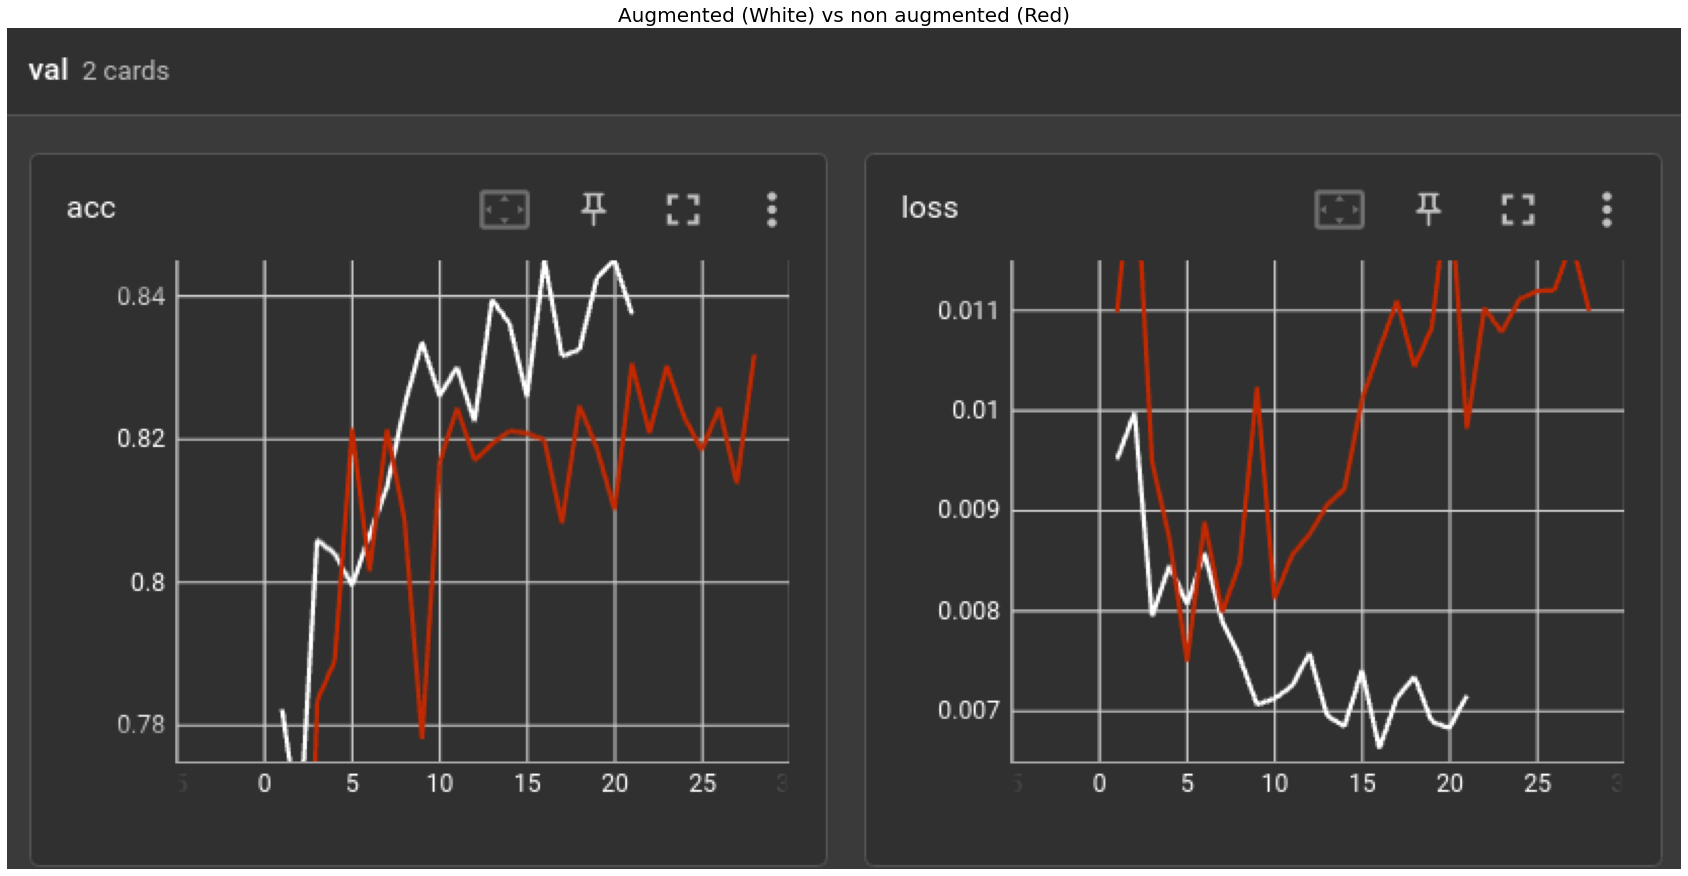

In [120]:
test_dataset = CustomDataset(annotations['test'], 
                             img_dir=data_dir, 
                             transform=img_transforms)
gen = torch.Generator()
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True, generator=gen)

from PIL import Image
summary = Image.open('result.png')
plt.rcParams['text.color'] = 'black'
plt.figure(figsize=(30, 20))
plt.imshow(summary)
plt.axis('off');
plt.title('Augmented (White) vs non augmented (Red)', fontsize=20);


### Models tests on unseed data

In [70]:
def test_model(dataset, test_loader, model):
    device = torch.device('cuda')
    model.to(device)

    model.eval()
    results = []
    labels = []

    correct = 0
    acc = 0
    most_mistakes = 0

    with torch.no_grad():
        gen.manual_seed(2809)
        
        progress_bar = tqdm(list(test_loader))
        for batch_idx, (data, target) in enumerate(progress_bar):
            data, target = data.to(device), target.to(device)
            out = model(data)
            results.append(out)
            labels.append(target)
            predictions = torch.max(out, dim=1)[1]
            correct += torch.count_nonzero(predictions.eq(target))
            progress_bar.set_description('Test accuracy: {:.2f}%'.format(100*(correct / ((batch_idx+1)*64)).cpu().numpy()))
            mistakes = torch.count_nonzero(~aug_results[2][1].eq(aug_results[2][2]))
            if mistakes > most_mistakes:
                most_mistakes = mistakes
                worst_batch = (data, target, predictions)
                
    return results, labels, worst_batch

In [72]:
# no augmentation
model = torch.load('effnetv2_unfreezed_noaug.pt')
no_aug_results = test_model(test_dataset, test_loader, model)

Test accuracy: 82.00%: 100%|██████████████████| 141/141 [00:12<00:00, 11.58it/s]


In [73]:
del model
torch.cuda.empty_cache()

In [74]:
# augmentation
model = torch.load('effnetv2_pretrained_aug.pth')
aug_results = test_model(test_dataset, test_loader, model)

Test accuracy: 83.68%: 100%|██████████████████| 141/141 [00:12<00:00, 11.05it/s]


In [75]:
del model
torch.cuda.empty_cache()

### Confusion matrices

In [144]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_cms(results1, results2):
    pred1 = np.hstack([torch.max(_, dim=1)[1].cpu().numpy() for _ in results1[0]])
    pred2 = np.hstack([torch.max(_, dim=1)[1].cpu().numpy() for _ in results2[0]])
    
    gt1 = np.hstack([_.cpu().numpy() for _ in results1[1]])
    gt2 = np.hstack([_.cpu().numpy() for _ in results2[1]])
    
    cm1 = confusion_matrix(gt1, pred1)
    cm2 = confusion_matrix(gt2, pred2)
    
    fig, axs = plt.subplots(1, 2, figsize=(13, 13))
    
    disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=classes)
    disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=classes)
    
    disp1.plot(xticks_rotation='vertical', ax=axs[0], colorbar=False)
    disp2.plot(xticks_rotation='vertical', ax=axs[1], colorbar=False)
    
    axs[0].set_title('Not augmented dataset')
    axs[1].set_title('Augmentated dataset')
    fig.tight_layout()
    plt.tick_params(axis=u'both', which=u'both',length=0)
    axs[0].grid(b=None)
    axs[1].grid(b=None)
    return cm1, cm2

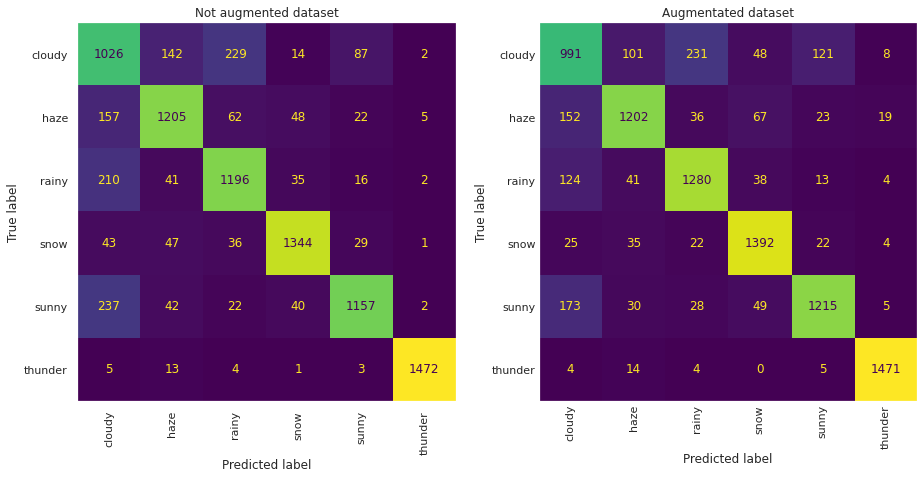

In [145]:
cms = plot_cms(no_aug_results[:2], aug_results[:2])

### Where augmentation actually helped?

In [146]:
correct_helper = np.eye(cms[0].shape[0])
correct_no_aug = correct_helper * cms[0]
correct_aug = correct_helper * cms[1]

wrong_helper = np.ones((cms[0].shape[0], cms[0].shape[0])) - help_matrix
wrong_no_aug = wrong_helper * cms[0]
wrong_aug = wrong_helper * cms[1]

In [147]:
aug = correct_aug - correct_no_aug

In [148]:
differences = (wrong_no_aug - wrong_aug) + aug

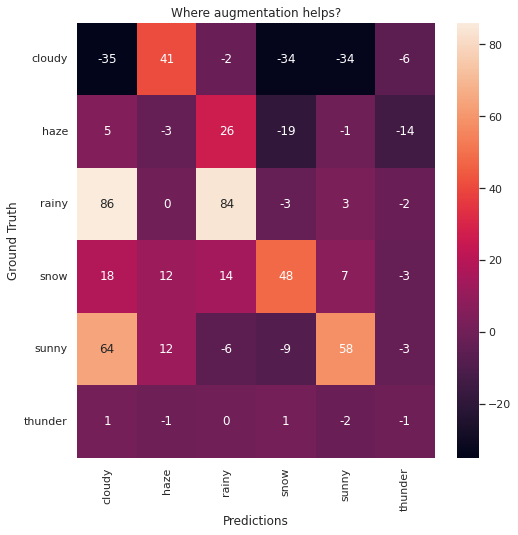

In [149]:
import seaborn as sns
sns.set(rc={'figure.figsize':(8, 8)})
diff = sns.heatmap(differences, annot=True, xticklabels=classes)
diff.set_yticklabels(classes, rotation=0);
diff.set_xticklabels(classes, rotation=90);
diff.set(xlabel='Predictions', ylabel='Ground Truth');
diff.set_title('Where augmentation helps?');
# score > 0 -> augmentation helps

### Test results comparison between augmentation and no augmentation

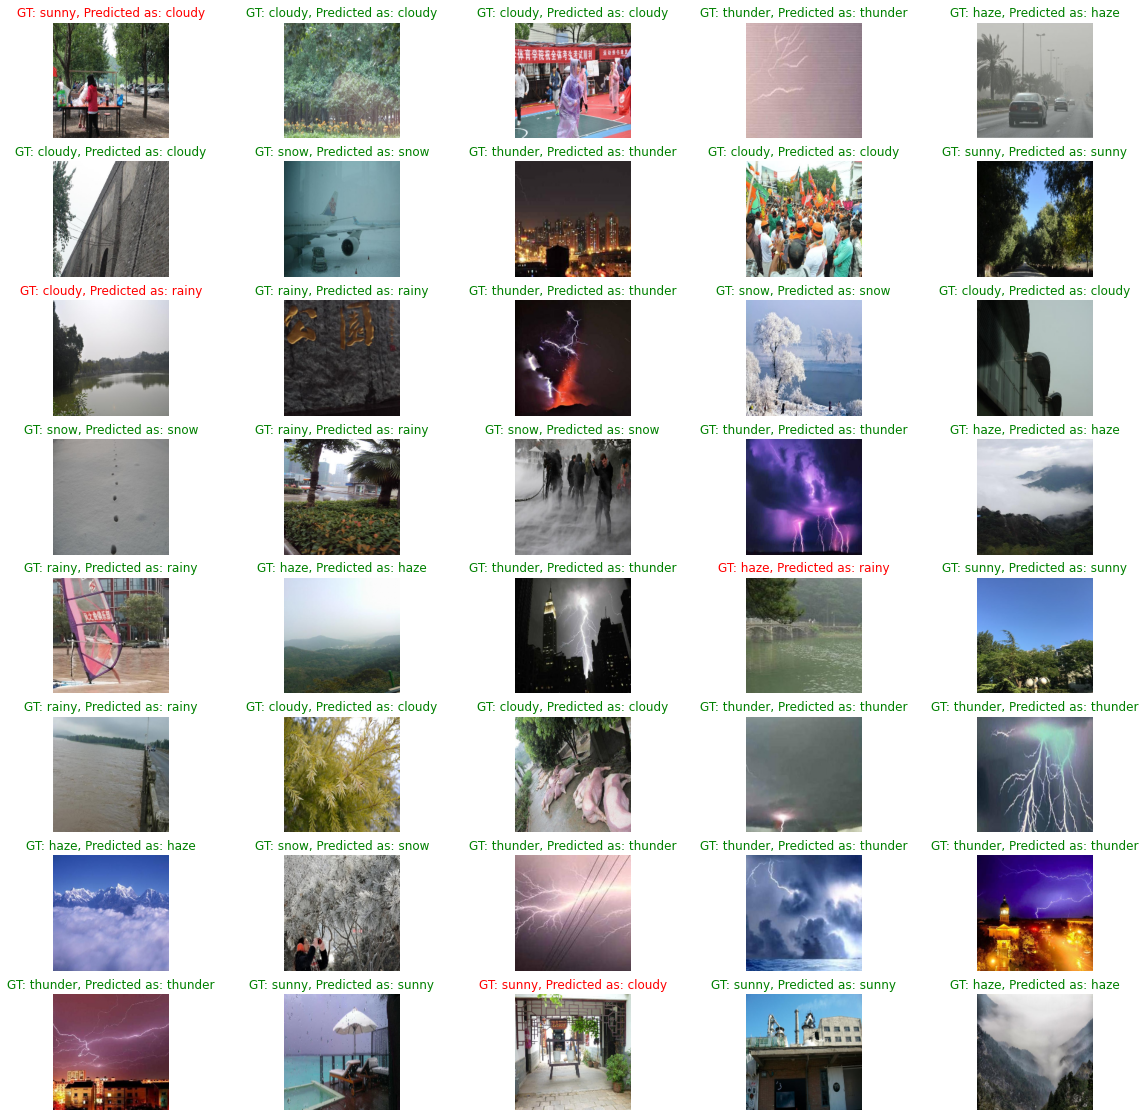

In [97]:
# non augmented
plt.figure(figsize=(20, 20))
for i, (img, gt, pred) in enumerate(zip(no_aug_results[2][0][24:], no_aug_results[2][1][24:], no_aug_results[2][2][24:])):
    plt.rcParams['text.color'] = 'g' if gt == pred else 'r'
    plt.subplot(8, 5, i+1)
    plt.imshow(img.cpu().numpy().squeeze().transpose(1, 2, 0))
    plt.title(f'GT: {classes[int(gt)]}, Predicted as: {classes[pred]}')
    plt.axis('off')

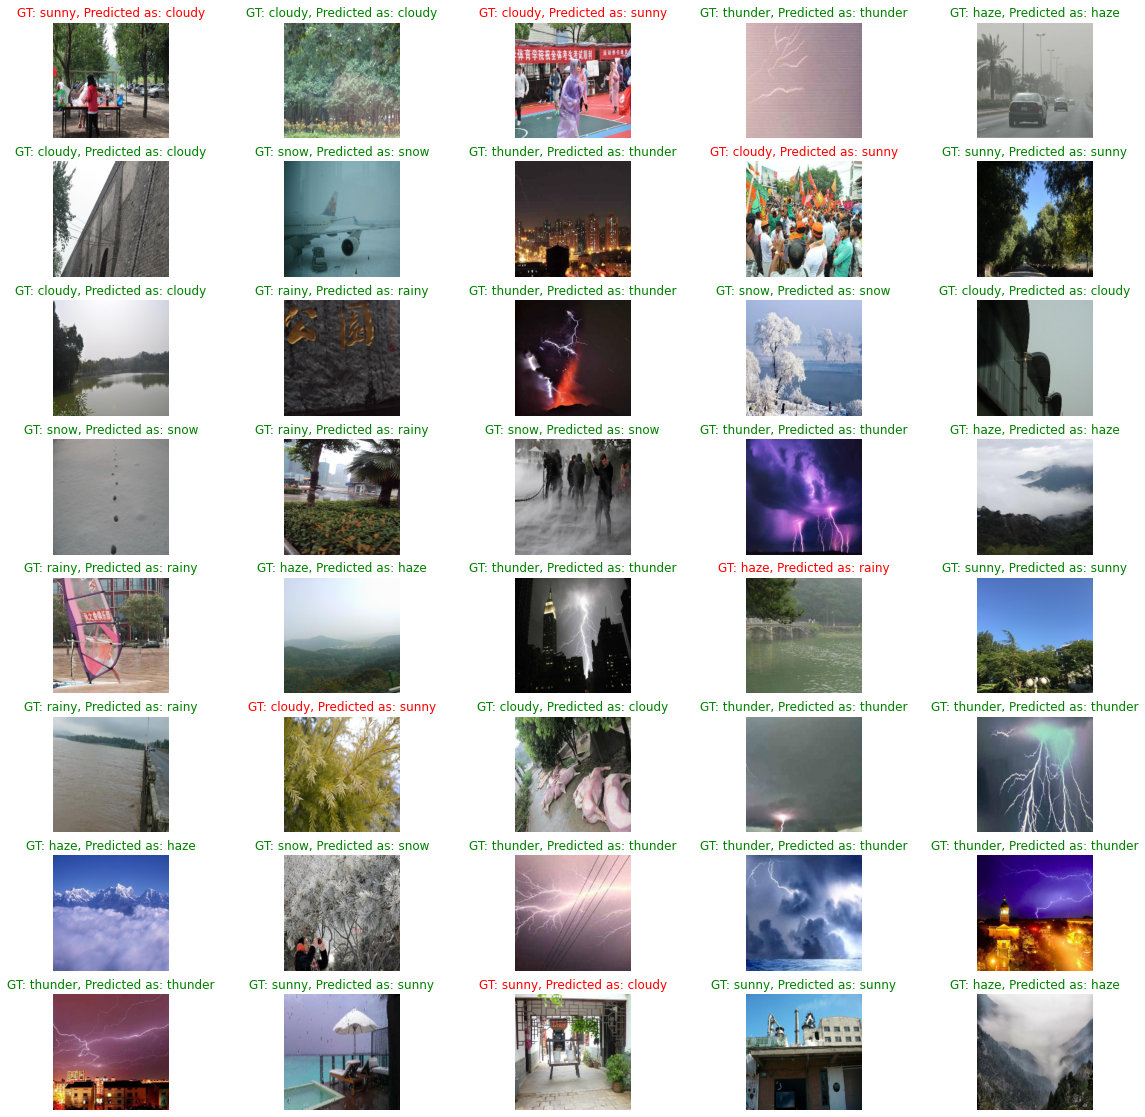

In [108]:
# augmented
plt.figure(figsize=(20, 20))

for i, (img, gt, pred) in enumerate(zip(aug_results[2][0][24:], aug_results[2][1][24:], aug_results[2][2][24:])):
    plt.rcParams['text.color'] = 'g' if bool(gt == pred) else 'r'
    plt.subplot(8, 5, i+1)
    plt.imshow(img.cpu().numpy().squeeze().transpose(1, 2, 0))
    plt.title(f'GT: {classes[int(gt)]}, Predicted as: {classes[pred]}')
    plt.axis('off')

# Wyślij rozwiązanie
Możesz skorzystać z jednego z poniższych sposobów:
**mailem na specjalny adres** ze strony pracy domowej w panelu programu prześlij jedno z poniższych:
- notebooka (jeżeli plik ma mniej niż np. 10MB)
- notebooka w zipie
- link do Colaba (udostępniony)
- link do pliku przez GDrive/Dropboxa/WeTransfer/...
- pdfa (poprzez download as pdf)
- jako plik w repozytorium na np. GitHubie, by budować swoje portfolio (wtedy uważaj na wielkość pliku, najlepiej kilka MB, Max 25MB)

Najlepiej, by w notebooku było widać wyniki uruchomienia komórek, chyba, że przez nie plik będzie mieć 100+MB wtedy najlepiej Colab lub jakieś przemyślenie co poszło nie tak (zbyt dużo dużych zdjęć wyświetlonych w komórkach).

## Co otrzymasz?
Informację zwrotną z ewentualnymi sugestiami, komentarzami.